In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

import os
import datetime as dt
from functools import wraps

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, random_state
from utils.utils import *
from utils.cast_data import apply_datetime_format
from src.src import *

In [4]:
# ToDos

# ff_HML stationary?

# need to force normal distribution?

# test features for heteroskedasticity against time?

# resolve multicolinerarity -> orthogonolisation
#     start off with highest correlation variables
    
# Regression
#     select variables
#     consider sp_cloes t-1

In [5]:
df_all = load_data(file_name="merged_data.csv", file_path=WORK_DATA_DIR)
df_all.sort_values("date", inplace=True)

data_dict = load_data(file_name="data_dict.pkl", file_path=WORK_DATA_DIR)

df_w = cut_to_weekly_data(df_all).reset_index(drop=True).copy()
df_w = shift_var_relative_to_df(df_w, shift_var="sp_close", new_var_name=["sp_close_lag1", "sp_close_lag2", "sp_close_lag3"], no_lags=[-1, -2, -3])


('nan format unknonw',)
('nan format unknonw',)
Unknown columns found
['date', 'date_week']


In [6]:
data_dict.update(predicted="sp_close_lag1")
data_dict.update(sp_cols=["sp_close", "sp_close_lag1", "sp_close_lag2", "sp_close_lag3"])


relevant_cols=[
    'fears35',
    'vixo',
    'naaim_ind',
    'ff_M_RF',
    'ff_SMB',
    'ff_HML',
    'ff_RMW',
    'ff_CMA',
    'ff_RF',
    'termspread',
    'pc_ratio',
    'aaii_Bullish'
] 
relevant_cols = relevant_cols + data_dict["sp_cols"]

data_dict.update(relevant_cols=relevant_cols)
data_dict.update(predictor=[item for item in data_dict["relevant_cols"] if item != data_dict["predicted"]])

In [7]:
# stationarity
stest = StatsTest(plot=False)

stationarity = stest.df_test_stationarity(df_w, data_dict["relevant_cols"])
data_dict.update(stationarity=stationarity)

normality = stest.df_test_normality(df_w, cols=data_dict["relevant_cols"])
data_dict.update(normality=normality)

In [8]:
# log transform
trans = DataTransformation(df_w,
                           data_dict)
trans.df_log_returns(["termspread", "vixo", "naaim_ind"] + data_dict["sp_cols"])

df_w = trans.df
data_dict = trans.dict_
df_w.dropna(inplace=True)

In [9]:
# stationarity
stest = StatsTest(plot=False)

stationarity = stest.df_test_stationarity(df_w, data_dict["relevant_cols"])
data_dict.update(stationarity=stationarity)

normality = stest.df_test_normality(df_w, cols=data_dict["relevant_cols"])
data_dict.update(normality=normality)

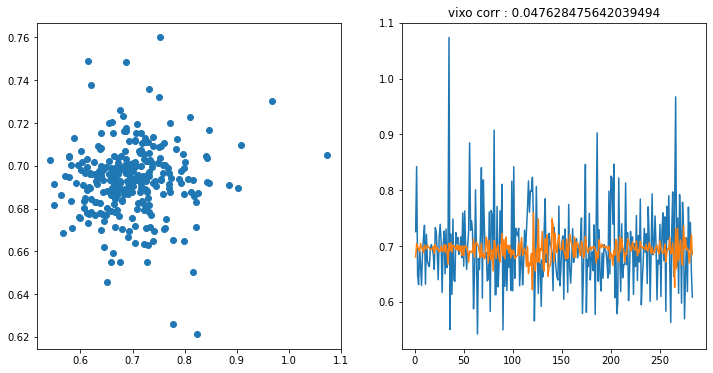

In [10]:
arr = df_w["vixo"]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].scatter(arr, df_w["sp_close_lag1"])
plt.title(f"{arr.name} corr : {arr.corr(df_w['sp_close_lag1'])}")

ax[1].plot(arr)
ax[1].plot(df_w.sp_close_lag1)

In [11]:
df_w[data_dict["relevant_cols"]].corrwith(df_w[data_dict["predicted"]]).sort_values(ascending=False)

sp_close_lag1    1.000000
fears35          0.188962
ff_RMW           0.090212
termspread       0.077866
pc_ratio         0.067690
vixo             0.047628
sp_close_lag3    0.044861
ff_CMA           0.035712
aaii_Bullish     0.017591
naaim_ind        0.011423
ff_RF            0.000406
ff_HML          -0.069735
ff_SMB          -0.112497
sp_close_lag2   -0.178568
sp_close        -0.179094
ff_M_RF         -0.209542
dtype: float64

# correlation

In [12]:
cols = [
    # 'vixo',
    'fears35',
     # 'naaim_ind',
     # 'ff_M_RF',
    #  'ff_SMB',
    #  'ff_RMW',
    #  'ff_CMA',
    #  'termspread',
    #  'pc_ratio',
    #  'aaii_Bullish',
    # 'ff_HML'
]

In [13]:
df_ws = df_w[cols + data_dict["sp_cols"]].copy()

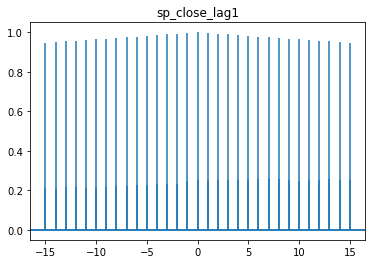

In [14]:
# lag correlation
max_lag = 15
for col in cols + [data_dict["predicted"]]:
    # plt.figure()
    x = plt.xcorr(df_ws[col], df_ws[data_dict["predicted"]], maxlags=max_lag)
    max_corr_ind = pd.DataFrame(x[1], x[0]).abs().loc[:0].sort_values(0).iloc[-1].name
    if max_corr_ind != 0:
        print(f"Highest correlation of {col} with {data_dict['predicted']} at {max_corr_ind}")
       
    plt.title(col)
    # plt.show()

In [15]:
# correlation with y
df_ws[cols].corrwith(df_ws[data_dict["predicted"]]).sort_values(ascending=False)

fears35    0.188962
dtype: float64

# Multicolinerarity

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [17]:
vif = pd.DataFrame([cols,
                    [variance_inflation_factor(df_ws[cols].values, i) for i in range(df_ws[cols].shape[1])]],
                   index=["features", "VIF"]).transpose().sort_values("VIF", ascending=False)
vif.set_index("features", inplace=True)
vif = vif.join(df_ws[cols].corrwith(df_ws[data_dict["predicted"]]).sort_values(ascending=False).rename('corr_predicted'))

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
vif

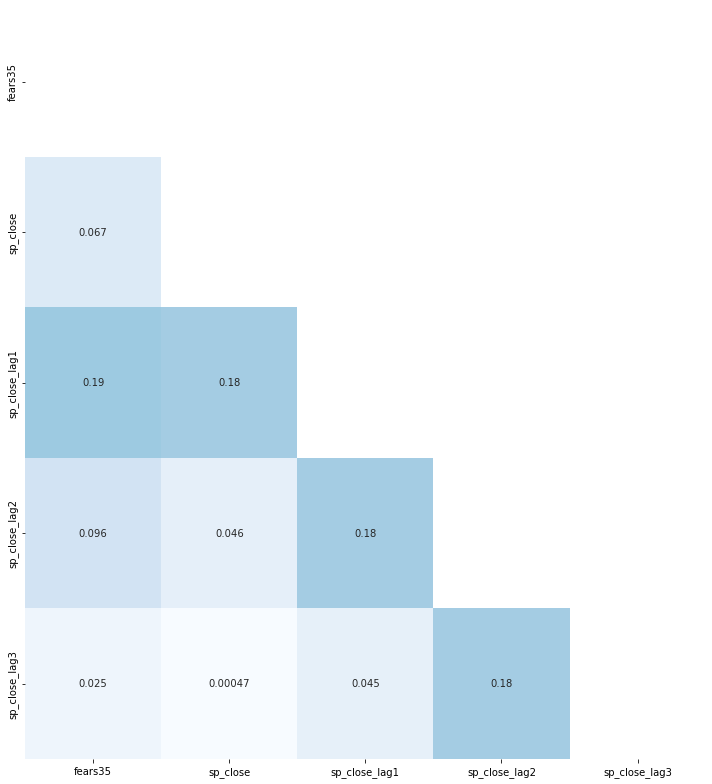

In [18]:
corr_matrix = df_ws.corr()
mask = np.triu(corr_matrix)

plt.figure(figsize=(10, 11))
sns.heatmap(abs(corr_matrix),
            annot=True,
            cmap="Blues",
            vmin=0,
            vmax=.5,
           mask=mask,
           cbar=False)
plt.tight_layout()

# Regression 2

In [19]:
import statsmodels.api as sm

In [20]:
df_train = df_ws.copy()

In [21]:
X_train, X_test, y_train, y_test = tts_data(df_train, y=data_dict["predicted"], x=cols, random_split=False)

In [22]:
model = sm.OLS(y_train, X_train).fit()

In [23]:
model.pvalues < 0.05

fears35      True
intercept    True
dtype: bool

In [24]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          sp_close_lag1   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     7.633
Date:                Tue, 01 Mar 2022   Prob (F-statistic):            0.00628
Time:                        09:47:46   Log-Likelihood:                 529.73
No. Observations:                 198   AIC:                            -1055.
Df Residuals:                     196   BIC:                            -1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
fears35        0.0065      0.002      2.763      0.006       0.002       0.011
intercept      0.6925      0.001    568.973      0.000       0.690       0.695
==============================================================================
Omnibus:                       18.410   Durbin-Watson:                   2.227
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.644
Skew:                          -0.036   Prob(JB):                     1.24e-15
Kurtosis:                       5.884   Cond. No.                         1.99
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Prediction

In [25]:
y_pred = model.predict(X_test)
resid = y_test - y_pred

In [26]:
from sklearn.metrics import r2_score
print("Validation Scores")
print(f'mean squared error: {round(np.mean((y_pred - y_test) ** 2), 8)}')
print(f'mean average error: {round(np.mean((y_pred - y_test) ** 2), 8)}')
print(f'R2: {round(r2_score(y_test, y_pred), 4)}')

Validation Scores
mean squared error: 0.00025629
mean average error: 0.00025629
R2: 0.0307


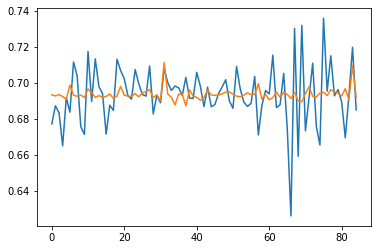

In [27]:
plt.plot(y_test)
plt.plot(y_pred)

Errors

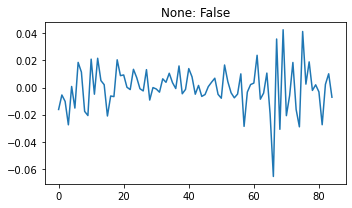

Stationarity Test Results
P-Values: 0.060016156868567115
Test-stats: -2.787947199642413
Time series is stationary: False


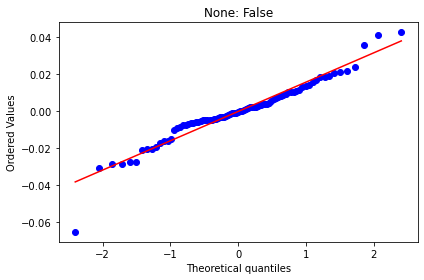

Normality Test Results
P-Values: 0.0013031025013190694
Test-stats: 13.286014636601935
Series is normally distributed: False


False

In [28]:
stest = StatsTest(print_results=True)
stest.arr_stationarity_adfuller(resid)
stest.arr_test_normality(resid)

In [30]:
def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, hold=None, **kwargs):
    return scatter(rand_jitter(x), rand_jitter(y), s=s, c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, **kwargs)

Test for Heteroskedasticity
Test p-value: 0.6723715246120958
Heteroskedasticity is present: False


False

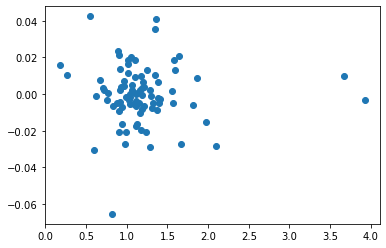

In [29]:
df_heteroskedasticity_white(y=resid, X=X_test)